In [1]:
from magicgui import magicgui
import datetime
import pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import napari
from magicclass import magicclass, field, get_function_gui
from magicclass.widgets import Figure, Table
import numpy as np
from scipy.stats import gaussian_kde
from tifffile import TiffFile
import vispy.color
from typing import List
from tqdm import tqdm

%config Completer.use_jedi = False


sns.set_style("ticks")
np.seterr(divide = 'ignore') 

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
def getLabels(tif_tags):
    substr = "<ScanColorTable-k>"
    start = 0
    strings = []
    while True:
        start = tif_tags['ImageDescription'].find(substr, start)
        if start == -1: # when '<ScanColorTable-k>' is not found
            break
        string = tif_tags['ImageDescription'][start+18:start+26]
        strings.append(string)
        start += 1
    marquages = []
    wl = []
    for s in strings:
        if s.startswith('DAPI'):
            marquages.append(s[0:4])
            wl.append('450')
        if s.startswith('Opal'):
            marquages.append(s)
            wl.append(s[5:])
            
    dictionary = {key: value for key, value in enumerate(wl)}
    # change to detailled list
    channel_list = [f'{value} (channel {key})' for key, value in enumerate(marquages)]

    return channel_list, dictionary

In [3]:
def get_cells(data, phe):
    dataPhe = []
    for p in phe:
        dataPhe.append(data.loc[data['phenotype'] == p])
    dataPhe = pd.concat(dataPhe)
    pointsPhe = np.column_stack((dataPhe['nucleus.x'], dataPhe['nucleus.y'])).astype(float)
    return pointsPhe

In [4]:
def convert_micro_to_pixels(tif_tags, points):
    scale = 10000
    #Compute min X and Y positions in micro meter
    X_ULHC = tif_tags['XPosition'][0]/tif_tags['XPosition'][1]*scale
    Y_ULHC = tif_tags['YPosition'][0]/tif_tags['YPosition'][1]*scale

    # Subtract the upper-left-hand corner (ULHC) 
    # to convert from the original system coordinate (full scan) to the cropped one
    x_values = (points[:,0] - X_ULHC) 
    y_values = (points[:,1] - Y_ULHC)
    
    # Get the resolution of the image
    numerator, denominator = tif_tags['XResolution']
    x_resolution = numerator / denominator
    numerator, denominator = tif_tags['YResolution']
    y_resolution = numerator / denominator
    resolution = np.array([x_resolution, y_resolution])/scale
    
    # Convert the coordinates to pixels
    points_ULHC = np.vstack((x_values, y_values)).T
    pixel_points = points_ULHC * resolution
    
    #save points in coordinates (0,0)
    points_microM = points - np.array([X_ULHC, Y_ULHC])

    return pixel_points, points_microM

In [5]:
# Fonction de Léo. Marchait bien mais ne va pas au dessus de 750 donc on avait les mature DC en noir.
# Nouvelle fonction dessous
"""
def wavelength_to_rgb(wavelength):
    gamma = 0.8
    intensity_max = 255

    factor = 0.0
    R = G = B = 0

    if (wavelength >= 380) and (wavelength < 440):
        R = -(wavelength - 440) / (440 - 380)
        G = 0.0
        B = 1.0
    elif (wavelength >= 440) and (wavelength < 490):
        R = 0.0
        G = (wavelength - 440) / (490 - 440)
        B = 1.0
    elif (wavelength >= 490) and (wavelength < 510):
        R = 0.0
        G = 1.0
        B = -(wavelength - 510) / (510 - 490)
    elif (wavelength >= 510) and (wavelength < 580):
        R = (wavelength - 510) / (580 - 510)
        G = 1.0
        B = 0.0
    elif (wavelength >= 580) and (wavelength < 645):
        R = 1.0
        G = -(wavelength - 645) / (645 - 580)
        B = 0.0
    elif (wavelength >= 645) and (wavelength <= 750):
        R = 1.0
        G = 0.0
        B = 0.0

    # Adjust intensity
    if (wavelength >= 380) and (wavelength <= 750):
        factor = 0.3 + 0.7 * (wavelength - 380) / (750 - 380)

    R = int(intensity_max * (R * factor)**gamma)
    G = int(intensity_max * (G * factor)**gamma)
    B = int(intensity_max * (B * factor)**gamma)

    return [R / 255.0, G / 255.0, B / 255.0]
"""

'\ndef wavelength_to_rgb(wavelength):\n    gamma = 0.8\n    intensity_max = 255\n\n    factor = 0.0\n    R = G = B = 0\n\n    if (wavelength >= 380) and (wavelength < 440):\n        R = -(wavelength - 440) / (440 - 380)\n        G = 0.0\n        B = 1.0\n    elif (wavelength >= 440) and (wavelength < 490):\n        R = 0.0\n        G = (wavelength - 440) / (490 - 440)\n        B = 1.0\n    elif (wavelength >= 490) and (wavelength < 510):\n        R = 0.0\n        G = 1.0\n        B = -(wavelength - 510) / (510 - 490)\n    elif (wavelength >= 510) and (wavelength < 580):\n        R = (wavelength - 510) / (580 - 510)\n        G = 1.0\n        B = 0.0\n    elif (wavelength >= 580) and (wavelength < 645):\n        R = 1.0\n        G = -(wavelength - 645) / (645 - 580)\n        B = 0.0\n    elif (wavelength >= 645) and (wavelength <= 750):\n        R = 1.0\n        G = 0.0\n        B = 0.0\n\n    # Adjust intensity\n    if (wavelength >= 380) and (wavelength <= 750):\n        factor = 0.3 +

In [6]:
"""
This function is based on code originally written in Fortran by Dan Bruton, 
and now available here: http://www.midnightkite.com/color.html. 
There are a number of implementations floating around in various languages (Pascal, R etc.), 
often with the logic tweaked slightly.
"""
def wavelength_to_rgb(nm):

    gamma = 0.8
    max_intensity = 255
    factor = 0

    rgb = {"R": 0, "G": 0, "B": 0}

    if 380 <= nm <= 439:
        rgb["R"] = -(nm - 440) / (440 - 380)
        rgb["G"] = 0.0
        rgb["B"] = 1.0
    elif 440 <= nm <= 489:
        rgb["R"] = 0.0
        rgb["G"] = (nm - 440) / (490 - 440)
        rgb["B"] = 1.0
    elif 490 <= nm <= 509:
        rgb["R"] = 0.0
        rgb["G"] = 1.0
        rgb["B"] = -(nm - 510) / (510 - 490)
    elif 510 <= nm <= 579:
        rgb["R"] = (nm - 510) / (580 - 510)
        rgb["G"] = 1.0
        rgb["B"] = 0.0
    elif 580 <= nm <= 644:
        rgb["R"] = 1.0
        rgb["G"] = -(nm - 645) / (645 - 580)
        rgb["B"] = 0.0
    elif 645 <= nm <= 780:
        rgb["R"] = 1.0
        rgb["G"] = 0.0
        rgb["B"] = 0.0

    if 380 <= nm <= 419:
        factor = 0.3 + 0.7 * (nm - 380) / (420 - 380)
    elif 420 <= nm <= 700:
        factor = 1.0
    elif 701 <= nm <= 780:
        factor = 0.3 + 0.7 * (780 - nm) / (780 - 700)

    if rgb["R"] > 0:
        rgb["R"] = int(max_intensity * ((rgb["R"] * factor) ** gamma))
    else:
        rgb["R"] = 0

    if rgb["G"] > 0:
        rgb["G"] = int(max_intensity * ((rgb["G"] * factor) ** gamma))
    else:
        rgb["G"] = 0

    if rgb["B"] > 0:
        rgb["B"] = int(max_intensity * ((rgb["B"] * factor) ** gamma))
    else:
        rgb["B"] = 0

    return (rgb["R"]/255, rgb["G"]/255, rgb["B"]/255)

---
# Change the input below

---

In [7]:
# Path for the .qptiff

# 1ere lame
#path = "../data/DC2 CheckUp B200332_Scan1/Scan1/DC2 CheckUp B200332_Scan1.qptiff"

# Test pierre
path = "../data/Pierre_good/DC2 CheckUp B191914_Scan1.qptiff"



In [8]:
# Load file
tif = TiffFile(path)
# Load multi channel image
img_data = tif.series[0].asarray()
# Get tags from DAPI channel in .pages
tif_tags = {}
for tag in tif.pages[0].tags.values():
    name, value = tag.name, tag.value
    tif_tags[name] = value

In [9]:
channel_list, channel_name_dictionary = getLabels(tif_tags)
channel_list

['DAPI (channel 0)',
 'Opal 570 (channel 1)',
 'Opal 690 (channel 2)',
 'Opal 480 (channel 3)',
 'Opal 620 (channel 4)',
 'Opal 780 (channel 5)',
 'Opal 520 (channel 6)']

---
# Change the input below

---

In [10]:
# Path to consolidated data_new

# 1ere lame
#file_path_csv = "../data/DC2 CheckUp B200332_Scan1 2/Consolidated_data_new.txt"

# Test pierre
file_path_csv = '../data/Pierre_good/Consolidated_data_new_good.txt'

In [11]:
data = pd.read_csv(file_path_csv, sep="\t")
data = data.dropna()

# Keep marker columns
cols = [i for i in data.columns if 
        i.startswith(("Nucleus", "Membrane", "Cytoplasm", "Cell")) and 
        i not in ["Cell ID", "Cell X Position", "Cell Y Position", "Nucleus Area (square microns)"]]

# Store possible celltypes in the dataframe
celltype_cols = [i for i in data.columns if i.startswith("Phenotype")]
celltype = [i.split()[1] for i in celltype_cols]

# Initialisation
x = np.log(data[cols[0]])
y = np.log(data[cols[1]])

In [12]:
# Donne la position du type cellulaire dans les colonnes
dico = {celltype_cols[i].split(" ")[1] : i for i in range(len(celltype_cols))}

In [13]:
# Adding phenotype column in dataframe

data_shrink = data[celltype_cols]

liste_phenotype = []

# Ordre d'assignation : 
# Pneumocyte -> cDC1 -> pDC -> cDC2 -> Mature_DC -> Tumor_cells -> CD8 -> Other
# Changer l'ordre s'il ne convient pas
for i in tqdm(range(len(data_shrink.index))): # tqdm pour barre de progression
    if "+" in data_shrink.iloc[i, dico["Pneumocyte"]]:
        liste_phenotype.append("Pneumocyte")
    elif "+" in data_shrink.iloc[i, dico["cDC1"]]:
        liste_phenotype.append("cDC1")
    elif "+" in data_shrink.iloc[i, dico["pDC"]]:
        liste_phenotype.append("pDC")
    elif "+" in data_shrink.iloc[i, dico["cDC2"]]:
        liste_phenotype.append("cDC2")
    elif "+" in data_shrink.iloc[i, dico["Mature_DC"]]:
        liste_phenotype.append("Mature_DC")
    elif "+" in data_shrink.iloc[i, dico["Tumor_cells"]]:
        liste_phenotype.append("Tumor_cells")
    elif "+" in data_shrink.iloc[i, dico["CD8"]]:
        liste_phenotype.append("CD8")
    else:
        liste_phenotype.append("Other")
        
data["Phenotype"] = liste_phenotype

100%|█████████████████████████████████| 628643/628643 [01:39<00:00, 6331.50it/s]


In [17]:
data["Phenotype"].value_counts()

Phenotype
Other          495667
Tumor_cells     75613
CD8             31631
Mature_DC       17758
cDC2             3169
cDC1             2661
pDC              1890
Pneumocyte        254
Name: count, dtype: int64

In [18]:
# Initialisation des inputs
slider_options = {"widget_type": "FloatSlider", "min": np.min(x), "max": np.max(x)}
dropdown_marker={"choices" : cols}
dropdown={"choices": cols}

Phenotypes = list(np.unique(data["Phenotype"]))

dropdown_celltype1 = {"widget_type" : 'Select', "choices" : Phenotypes, "value" : Phenotypes[0]}
dropdown_celltype2 = {"choices" : Phenotypes, "value" : Phenotypes[0]}

dropdown_inf_sup = {"choices" : ["Inferior", "Superior"], "value" : "Inferior"}

In [19]:
# Permet de dire si on veut une app qui rame un peu mais une image plus jolie

# Set to false if it's too laggy but the image will be less resoluted
BETTER_RESOLUTION = True

In [38]:
# Enleve erreur si pas la clé dans le dico
# Transforme tab en str pour ça
# Remove a threshold
## Faire un select input pour choisir ligne


@magicclass(widget_type = "tabbed", name = "Main")
class Widget:
    
    dico_thresholds = {}
    
    @magicclass(widget_type = "scrollable", name = "Visualisation")
    class W1:
        
        x_axis = field(options=dropdown_marker) # Dropdown menu to select x axis column
        y_axis = field(options=dropdown_marker) # Dropdown menu to select y axis column
        slider = field(float, options = slider_options) # Slider to fix cutoff
        celltype_dropdown = field(options = dropdown_celltype1, name = "Celltype") # Dropdown menu to select cells to show
        density = field(bool, options = {"value" : True}) # Checkbox to plot either a density plot or a scatter plot

        def invert(self):
            """
            Invert the x axis and y axis columns when pressed
            """
            t = self.x_axis.value
            self.x_axis.value = self.y_axis.value
            self.y_axis.value = t


        plot = field(Figure) # Plot object that will be displayed in the widget
        temp = pd.DataFrame() # Dataframe to work with the data without changing it


        def Calculate(self) -> napari.types.LayerDataTuple:
            """
            Add a point layer that highlight the selected cells according to the inputs
            """
            # Keep only the rows corresponding to the threshold and the celltype
            temporary = data[data["Phenotype"].isin(self.celltype_dropdown.value)]
            temp1 = temporary[np.log(temporary[self.x_axis.value]) > self.slider.value]
            xy = temp1[['Cell X Position', 'Cell Y Position']].values

            temp_neg = temporary[np.log(temporary[self.x_axis.value]) <= self.slider.value]
            xy_neg = temp_neg[['Cell X Position', 'Cell Y Position']].values

            # Write the number of keeped cells
            self.info.value = f"Selected {round(100*xy.shape[0]/temporary.shape[0], 2)}% of {self.celltype_dropdown.value} cells"

            # Convert micrometers coordinates in pixels coordinates
            pixel_points, points_microM = convert_micro_to_pixels(tif_tags, xy)
            # Convert coordinates to napari
            pixel_points_napari = pixel_points[:, ::-1]


            # Convert micrometers coordinates in pixels coordinates
            pixel_points_neg, points_microM_neg = convert_micro_to_pixels(tif_tags, xy_neg)
            # Convert coordinates to napari
            pixel_points_napari_neg = pixel_points_neg[:, ::-1]

            keeped_points = (pixel_points_napari, 
                    {"edge_color" : '#00aaffff',
                     "size" : 25,
                     "name" : f'{self.x_axis.value} > {round(pow(10,self.slider.value), 0)}'}, 
                    "points")
            removed_points = (pixel_points_napari_neg, 
                    {"face_color" : '#00000000', 
                     "edge_color" : '#ff0000', 
                     "size" : 25, 
                     "name" : f'{self.x_axis.value} < {round(pow(10,self.slider.value), 0)}'}, 
                    "points")


            return list((keeped_points, removed_points))


        @x_axis.connect
        @y_axis.connect
        @celltype_dropdown.connect
        def _plot(self):
            """
            When either the x axis selector or the y axis selector are modified, 
            clear the plot axes and show a new one
            """
            x_axis = self.x_axis.value
            y_axis = self.y_axis.value

            # keep only cells with the wanted phenotype
            temporary = data[data["Phenotype"].isin(self.celltype_dropdown.value)]
            index = temporary.index

            x = np.log(temporary[x_axis].values)
            y = np.log(temporary[y_axis].values)
            phenotype = temporary["Phenotype"].values


            # Convert to log (inf values generated so we needed extra steps to remove them)
            self.temp = pd.DataFrame({"x" : x, "y" : y, "Phenotype" : phenotype})
            self.temp = self.temp.replace([np.inf, -np.inf], np.nan)
            self.temp = self.temp.dropna()

            x = self.temp["x"]
            y = self.temp["y"]

            # Update slider min and max values because we changed the x axis
            self.slider.min = np.min(x)
            self.slider.max = np.max(x)

            # Call plot function defined later
            self._plot_wrapper()
            self.plot.ax.axis("auto")


        @slider.connect
        def _update_vline(self):
            """
            When the slider input is modified, clear the previous vline and draw a new one
            """
            while len(self.plot.ax.lines) > 0:
                self.plot.ax.lines[len(self.plot.ax.lines)-1].remove()

            position = self.slider.value
            self.plot.axvline(position, c = "red")

        @density.connect  
        def _plot_wrapper(self):
            """
            Function to plot
            """

            # Clear plot and label axes
            self.plot.cla()
            self.plot.ax.set(xlabel=self.x_axis.value, ylabel=self.y_axis.value)

            if self.temp.shape[0] > 10000:
                temporary = self.temp.sample(n=10000).copy()
                self.warning.value = f"Showing only 10 000 points out of {self.temp.shape[0]}"
            else:
                temporary = self.temp.copy()
                self.warning.value = ""


            # If density plot
            if self.density.value:
                values = np.vstack([temporary["x"], temporary["y"]])
                kernel = gaussian_kde(values)(values)


                sns.scatterplot(temporary, x = "x", y = 'y', ax = self.plot.ax, linewidth = 0, c = kernel, cmap = "Spectral_r")
                sns.kdeplot(temporary, x = "x", y = 'y', ax = self.plot.ax, gridsize = 35, levels=5, fill=True, alpha=0.2, cut=2)
                self.plot.autoscale()

            else: #Scatterplot
                sns.scatterplot(temporary, x = "x", y = 'y', ax = self.plot.ax, hue = "Phenotype")
                self.plot.autoscale()

            # Update the red vline
            self._update_vline()


        warning = field(str, options={"enabled": False})
        info = field(str, options={"enabled": False})
    
    @magicclass(widget_type = "scrollable", name = "Thresholds")
    class W2:
        
        celltype_dropdown_threshold = field(options = dropdown_celltype2, name = "Celltype") # Dropdown menu to select cells to set threshold
        Marker = field(options=dropdown_marker) # Dropdown menu to select the marker
        Comparison = field(options = dropdown_inf_sup)
        Threshold_value = field(float, name = "Threshold value (log10)")
        Annotation = field(options = {"choices" : [f"{celltype_dropdown_threshold.value}+", f"{celltype_dropdown_threshold.value}-"]})
        
        @celltype_dropdown_threshold.connect
        def _update_annotation(self):
            self.Annotation.choices = [f"{self.celltype_dropdown_threshold.value}+", f"{self.celltype_dropdown_threshold.value}-"]
        
        def Add_Threshold(self):
            if self.Comparison.value == "Inferior":
                comparison = "<"
            else:
                comparison = ">"
            
            temp_dico = {"Marker" : self.Marker.value[0:self.Marker.value.find("(")-1], 
                         "Comparison" : comparison,
                         "Value" : self.Threshold_value.value,
                         "Annotation" : self.Annotation.value}
            
            if self.celltype_dropdown_threshold.value not in Widget.dico_thresholds.keys():
                Widget.dico_thresholds[self.celltype_dropdown_threshold.value] = []
                
            if temp_dico not in Widget.dico_thresholds[self.celltype_dropdown_threshold.value]:
                Widget.dico_thresholds[self.celltype_dropdown_threshold.value].append(temp_dico)
            
    @magicclass(widget_type = "scrollable", name = "Export table")
    class W3:
        
        celltype_dropdown_table = field(options = dropdown_celltype2, name = "Celltype") # Dropdown menu to select cells to visualise thresholds
        
        def Actualise(self):
            self.table.value = Widget.dico_thresholds[self.celltype_dropdown_table.value]
            self.test.value = self.table.value
        
        table = field(Table, name = "Table")
        test = field(str)
        
        @celltype_dropdown_table.connect
        def _update_table(self):
            self.table.value = Widget.dico_thresholds[self.celltype_dropdown_table.value]
        
        
        @table.connect
        def _update_remove(self):
            self.Remove.Line_to_remove.choices = list(self.table.value["index"])
        
        
        @magicclass(layout="horizontal")
        class Remove:
            
            Line_to_remove = field(options = {"choices" : [0]})
            
            def Remove_line(self):
                temp = Widget.dico_thresholds[Widget.W3.celltype_dropdown_table.value]
                del(temp[self.Line_to_remove.value])
                Widget.dico_thresholds[Widget.W3.celltype_dropdown_table.value] = temp
                

ui = Widget()

viewer = napari.Viewer()
viewer.window.add_dock_widget(ui, area='right')


for i in range(len(channel_name_dictionary)):
    wavelength = int(channel_name_dictionary[i])
    rgb_values = wavelength_to_rgb(wavelength)
    colorMap = vispy.color.Colormap([[0.0, 0.0, 0.0], rgb_values])
    
    # Better resolution but less smooth
    if BETTER_RESOLUTION:
        rlayer = viewer.add_image([img_data[i], 
                                   img_data[i][::4, ::4], 
                                   img_data[i][::8, ::8], 
                                   img_data[i][::16, ::16], 
                                   img_data[i][::32, ::32],
                                  img_data[i][::64, ::64]], 
                                  name=channel_name_dictionary[i])
    # Fluider but worse resolution
    else:
        rlayer = viewer.add_image(img_data[i], name=channel_name_dictionary[i])
    
    rlayer.blending = 'additive'
    rlayer.colormap = colorMap


/Users/mscavino/Thèse/test/app_leo/mipa_env/lib/python3.9/site-packages/magicclass/widgets/_mpl_canvas.py:119: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self.figure.tight_layout()


In [18]:
# Faire export table avec les seuils

from magicclass.widgets import Table

In [19]:
from magicclass.types import WidgetTypeStr

WidgetTypeStr

typing.Literal['none', 'scrollable', 'draggable', 'split', 'collapsible', 'button', 'toolbox', 'tabbed', 'stacked', 'list', 'subwindows', 'groupbox', 'frame', 'resizable', 'mainwindow', 'hcollapsible']

---
# Trash code

---

In [20]:
    ###        
    #def _densityplot(self):
    #    df = self.temp.copy()
    #    df = df.to_numpy()
    #    x,y = df.T
    #    
    #    k = kde.gaussian_kde(df.T)
    #    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    #    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    #    
    #    self.plot.ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=plot.cm.Blues)
    #    self.plot.ax.contour(xi, yi, zi.reshape(xi.shape), levels = 20, antialiased = True)
    #    self.plot.autoscale()
        

In [21]:
pd.DataFrame(data[celltype_cols].value_counts())

count
Phenotype Other.x Phenotype CD8 Phenotype Tumor_cells Phenotype Mature_DC Phenotype Pneumocyte Phenotype Other.y Phenotype cDC1 Phenotype cDC2 Phenotype pDC        
Other+            CD8-          Tumor_cells-          Mature_DC-          Pneumocyte-          Other+            cDC1-          cDC2-          pDC-           495667
Other-            CD8-          Tumor_cells+          Mature_DC-          Pneumocyte-          Other+            cDC1-          cDC2-          pDC-            75613
                  CD8+          Tumor_cells-          Mature_DC-          Pneumocyte-          Other+            cDC1-          cDC2-          pDC-            31631
                  CD8-          Tumor_cells-          Mature_DC+          Pneumocyte-          Other+            cDC1-          cDC2-          pDC-            17758
Other+            CD8-          Tumor_cells-          Mature_DC-          Pneumocyte-          Other-            cDC1-          cDC2+          pDC-             2780
                                                                                                                 cDC1+          cDC2-          pDC-             2525
                                                                                                                 cDC1-          cDC2-          pDC+             1879
Other-            CD8-          Tumor_cells+          Mature_DC-          Pneumocyte-          Other-            cDC1-          cDC2+          pDC-              371
                                Tumor_cells-          Mature_DC-          Pneumocyte+          Other+            cDC1-          cDC2-          pDC-              254
                                                      Mature_DC+          Pneumocyte-          Other-            cDC1+          cDC2-          pDC-               88
                  CD8+          Tumor_cells-          Mature_DC-          Pneumocyte-          Other-            cDC1+          cDC2-          pDC-               46
                  CD8-          Tumor_cells-          Mature_DC+          Pneumocyte-          Other-            cDC1-          cDC2+          pDC-               15
                                Tumor_cells+          Mature_DC-          Pneumocyte-          Other-            cDC1-          cDC2-          pDC+                8
                  CD8+          Tumor_cells-          Mature_DC-          Pneumocyte-          Other-            cDC1-          cDC2+          pDC-                3
                                                                                                                                cDC2-          pDC+                2
                  CD8-          Tumor_cells+          Mature_DC-          Pneumocyte-          Other-            cDC1+          cDC2-          pDC-                2
                                Tumor_cells-          Mature_DC+          Pneumocyte-          Other-            cDC1-          cDC2-          pDC+                1

In [22]:
all_liste = []
data_shrink = data[celltype_cols]

for i in range(len(data_shrink.index)):
    liste = []
    for j in range(len(celltype_cols)):
        if "+" in data_shrink.iloc[i,j]:
            liste.append(celltype_cols[j])
    
    
    all_liste.append(tuple(liste))

In [23]:
pd.DataFrame(all_liste).value_counts()

0                      1                
Phenotype Other.x      Phenotype Other.y    495667
Phenotype Tumor_cells  Phenotype Other.y     75613
Phenotype CD8          Phenotype Other.y     31631
Phenotype Mature_DC    Phenotype Other.y     17758
Phenotype Other.x      Phenotype cDC2         2780
                       Phenotype cDC1         2525
                       Phenotype pDC          1879
Phenotype Tumor_cells  Phenotype cDC2          371
Phenotype Pneumocyte   Phenotype Other.y       254
Phenotype Mature_DC    Phenotype cDC1           88
Phenotype CD8          Phenotype cDC1           46
Phenotype Mature_DC    Phenotype cDC2           15
Phenotype Tumor_cells  Phenotype pDC             8
Phenotype CD8          Phenotype cDC2            3
                       Phenotype pDC             2
Phenotype Tumor_cells  Phenotype cDC1            2
Phenotype Mature_DC    Phenotype pDC             1
Name: count, dtype: int64

In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [25]:
cols_phenotype = cols.copy()
cols_phenotype.append("Phenotype")

df = data[cols_phenotype]
std_scaler = StandardScaler()
scaled_df = std_scaler.fit_transform(df.iloc[:,:-1])

In [26]:
pca = PCA()
X_pca = pca.fit_transform(scaled_df)

In [27]:
print(sum(pca.explained_variance_ratio_))

1.0


In [28]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='rainbow')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

<Figure size 800x600 with 1 Axes>

In [29]:
for i in range(X_pca.shape[1]):
    column_name = f"PC{i+1}"
    df[column_name] = X_pca[:,i]

/var/folders/0l/5dgm9v295cz3jngvfm2pmflh0000gn/T/ipykernel_2950/195918505.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = X_pca[:,i]
/var/folders/0l/5dgm9v295cz3jngvfm2pmflh0000gn/T/ipykernel_2950/195918505.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = X_pca[:,i]
/var/folders/0l/5dgm9v295cz3jngvfm2pmflh0000gn/T/ipykernel_2950/195918505.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [30]:
X_pca.shape

(628643, 15)

KeyboardInterrupt: 

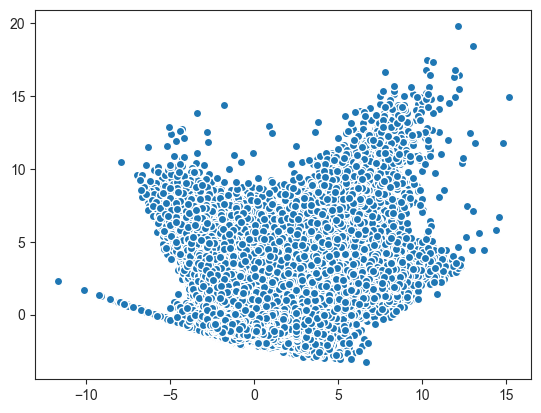

In [31]:
%matplotlib inline
sns.scatterplot(df, x= "PC1", y = "PC2", hue = "Phenotype")
plt.show()

In [ ]:
pip install umap-learn

In [ ]:
import umap

In [ ]:
reducer = umap.UMAP()
tsne = TSNE()

In [ ]:
cols_phenotype = cols.copy()
cols_phenotype.append("Phenotype")

df = data[cols_phenotype]
std_scaler = StandardScaler()
scaled_df = std_scaler.fit_transform(df.iloc[:,:-1])

In [ ]:
embedding = reducer.fit_transform(scaled_df)
embedding.shape

In [ ]:
for i in range(embedding.shape[1]):
    column_name = f"UMAP {i+1}"
    df[column_name] = embedding[:,i]

In [ ]:
wavelength_to_rgb(690)